In [1]:
library(brms)
theme_set(theme_default())

Loading required package: Rcpp
Loading required package: ggplot2
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.


# Load data

In [2]:
# load RData into environment object ("ex")
load("./prepped_data.RData", ex <- new.env())

In [3]:
# Load data from environment.
# For testing, we're using df_slice, which has only subjects 1 an 2.
#df <- ex$df_slice
df <- ex$df_total

In [4]:
head(df)

Answer,Block,CD,Choice,ED,RT,Trlnum,conNT,conNT_cent,item_id,newNT,newNT_cent,sub,task
1,0,1.140978,0,15.32376,1.762020,0,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc
0,1,1.140978,1,15.32376,2.242939,33,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc
1,2,1.140978,0,15.32376,1.766368,39,8.711341,-0.02945527,16.0,6.996014,0.002536885,1,disc
1,0,1.140978,0,15.32376,2.559490,38,8.711341,-0.02945527,16.0,6.996014,0.002536885,2,disc
1,2,1.140978,0,15.32376,2.417423,51,8.711341,-0.02945527,16.0,6.996014,0.002536885,2,disc
0,0,1.140978,1,15.32376,1.718840,2,8.711341,-0.02945527,16.0,6.996014,0.002536885,3,disc


In [5]:
str(df)

'data.frame':	11683 obs. of  14 variables:
 $ Answer    : Factor w/ 2 levels "0","1": 2 1 2 2 2 1 1 2 2 2 ...
 $ Block     : Factor w/ 3 levels "0","1","2": 1 2 3 1 3 1 2 3 1 2 ...
 $ CD        : num  1.14 1.14 1.14 1.14 1.14 ...
 $ Choice    : int  0 1 0 0 0 1 2 0 0 0 ...
 $ ED        : num  15.3 15.3 15.3 15.3 15.3 ...
 $ RT        : num  1.76 2.24 1.77 2.56 2.42 ...
 $ Trlnum    : int  0 33 39 38 51 2 51 46 31 6 ...
 $ conNT     : num  8.71 8.71 8.71 8.71 8.71 ...
 $ conNT_cent: num  -0.0295 -0.0295 -0.0295 -0.0295 -0.0295 ...
 $ item_id   : Factor w/ 64 levels "0.0","1.0","10.0",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ newNT     : num  7 7 7 7 7 ...
 $ newNT_cent: num  0.00254 0.00254 0.00254 0.00254 0.00254 ...
 $ sub       : Factor w/ 32 levels "1","10","11",..: 1 1 1 12 12 23 23 23 27 27 ...
 $ task      : Factor w/ 2 levels "disc","name": 1 1 1 1 1 1 1 1 1 1 ...


# Null models

In [6]:
# Build a null model, which assumes full random effects structure and a fixed effect for learning across blocks,
# but no influence of any neural typicality measure.
answer_nullmodel <- brm(Answer ~ Block + (Block|sub) + (1|item_id) + (1|task),
                        data = df,
                        family = bernoulli,
                        file = "answer_nullmodel",
                        chains = 2, cores = 2)

In [7]:
# Null model with varying slope for Block over tasks and over subjects
answer_nullmodel2 <- brm(Answer ~ Block + (Block|sub) + (Block|task) + (1|item_id),
                        data = df,
                        family = bernoulli,
                        file = "answer_nullmodel2",
                        chains = 2, cores = 2)

In [8]:
# Null model with random slope for block and task as well as their interaction across subjects
answer_nullmodel3 <- brm(Answer ~ Block*task + (Block*task|sub) + (1|item_id),
                        data = df,
                        family = bernoulli,
                        file = "answer_nullmodel3",
                        chains = 2, cores = 2)

In [9]:
# Null model equivalent to nullmodel3, but with random item slope over tasks.
#answer_nullmodel4 <- brm(Answer ~ Block*task + (Block*task|sub) + (item_id|task),
#                        data = df,
#                        family = bernoulli,
#                        file = "answer_nullmodel4",
#                        chains = 2, cores = 2)

In [10]:
# Null model 4 cannot be evaluated by stan

#summary(answer_nullmodel4)

Compare null models:

In [11]:
waic_nullmodcomp <- waic(answer_nullmodel, answer_nullmodel2, answer_nullmodel3)

In [12]:
waic_nullmodcomp

                                          WAIC    SE
answer_nullmodel                      13557.19 94.08
answer_nullmodel2                     13562.06 93.97
answer_nullmodel3                     13519.29 94.84
answer_nullmodel - answer_nullmodel2     -4.86  1.49
answer_nullmodel - answer_nullmodel3     37.90 14.26
answer_nullmodel2 - answer_nullmodel3    42.77 14.16

Null model 3 fits best. (The next more complex model, number 4, could not be evaluated). Hence, We should also use its random effects structure for testing our models of interest.

# Neural typicality models

In [13]:
# Add the newfound neural typicality measure to the model
answer_newNT <- brm(Answer ~ newNT_cent*Block*task + (newNT_cent*Block*task|sub) + (1|item_id),
                    data = df,
                    family = bernoulli,
                    file = "answer_newNT",
                    chains = 2, cores = 2)

In [14]:
#summary(answer_newNT)

In [15]:
# Model with conserved neural typicality
answer_conNT <- brm(Answer ~ conNT_cent*Block*task + (conNT_cent*Block*task|sub) + (1|item_id),
                    data = df,
                    family = bernoulli,
                    file = "answer_conNT",
                    chains = 2, cores = 2)

In [16]:
#summary(answer_conNT)

In [17]:
# model with both neural typicality measures
answer_bothNT <- brm(Answer ~ newNT_cent*conNT_cent*Block*task + (newNT_cent*conNT_cent*Block*task|sub) + (1|item_id),
                    data = df,
                    family = bernoulli,
                    file = "answer_bothNT",
                    chains = 2, cores = 2)

In [18]:
#summary(answer_bothNT)

Compare neural typicality models (with each other and null model)

In [19]:
# WAIC
waic_modcomp <- waic(answer_conNT, answer_newNT, answer_bothNT, answer_nullmodel3)

In [20]:
print(waic_modcomp)

                                      WAIC    SE
answer_conNT                      13514.21 95.31
answer_newNT                      13502.09 95.16
answer_bothNT                     13497.68 95.96
answer_nullmodel3                 13519.29 94.84
answer_conNT - answer_newNT          12.13 13.93
answer_conNT - answer_bothNT         16.53 12.92
answer_conNT - answer_nullmodel3     -5.07 10.54
answer_newNT - answer_bothNT          4.41 12.00
answer_newNT - answer_nullmodel3    -17.20 11.18
answer_bothNT - answer_nullmodel3   -21.61 16.43


In [21]:
# Leave-One-Out cross-validation (takes long to run)
#loo_modcomp <- loo(answer_conNT, answer_newNT, answer_bothNT, answer_nullmodel)
#print(loo_modcomp)

In [22]:
# retrieve individual fit measures
#waic_modcomp$answer_bothNT$estimates

Order of model fit (smaller values indicate better model):

- WAIC:
    - both NT < new NT < con NT < null model
    - For both NT & new NT, the difference to the null model is larger than the SE. 
    - The difference between con NT and null model is much smaller than the SE.
    - The difference between new NT and both NT is also much smaller than the SE.

# Visualization

In [23]:
# all posteriors
#plot(answer_newNT, ask = FALSE)

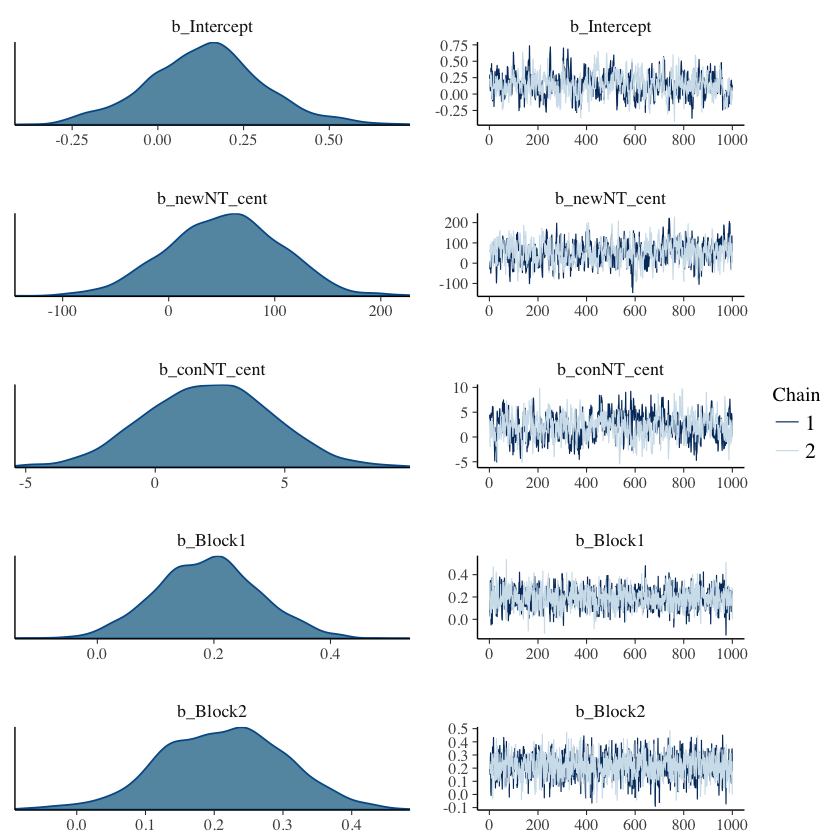

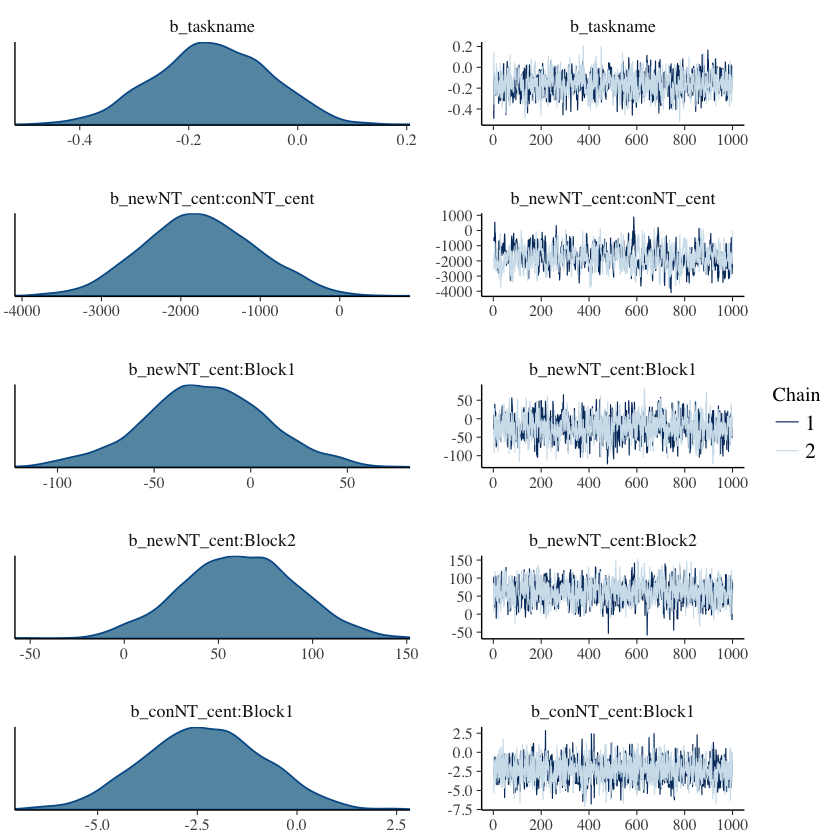

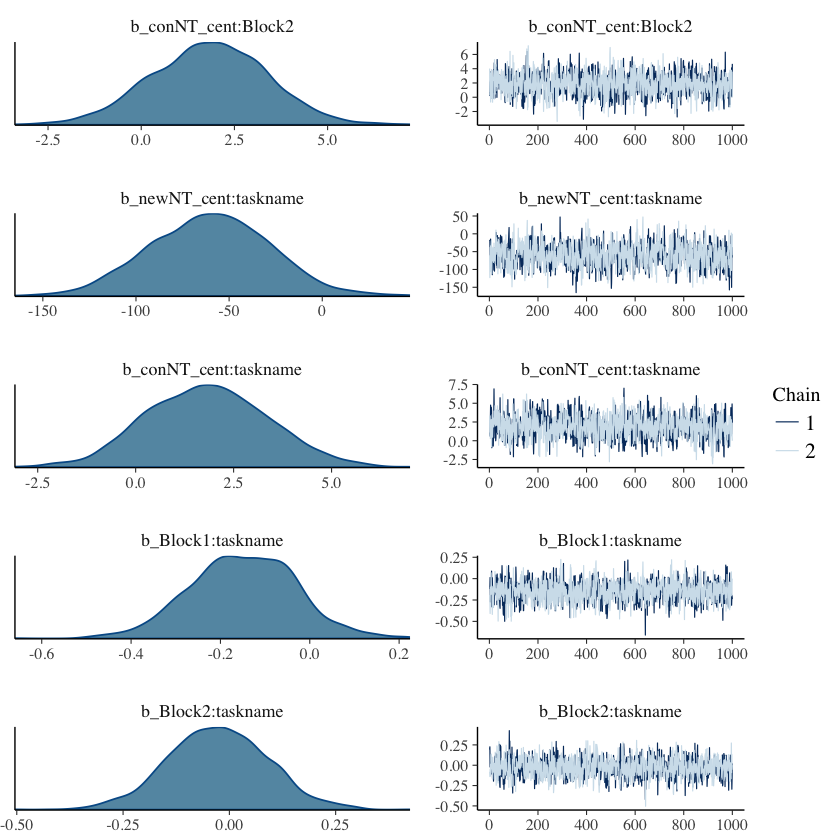

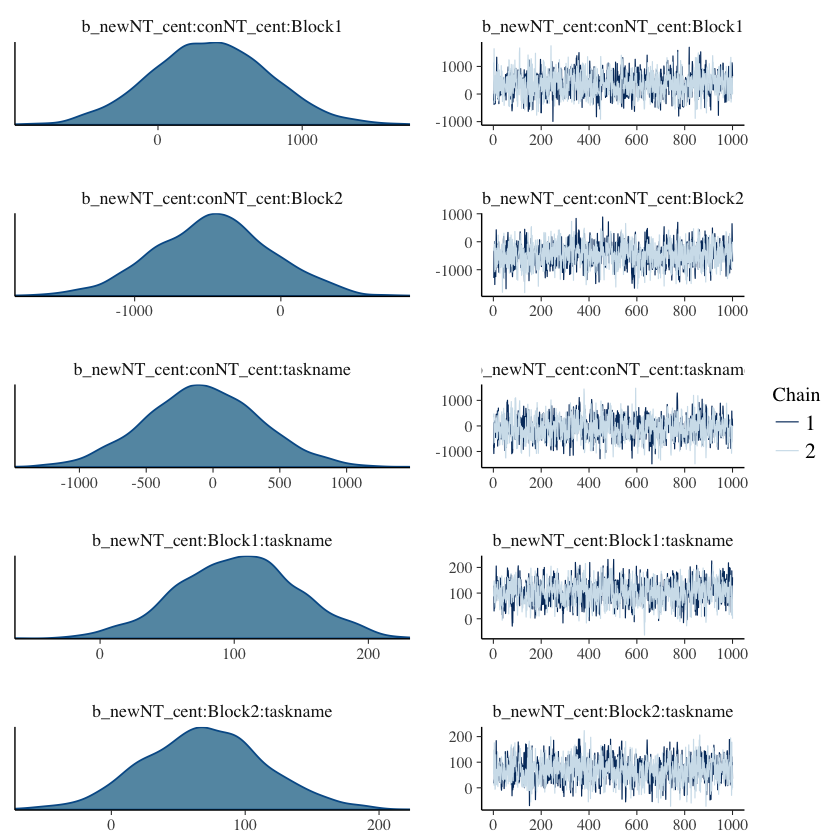

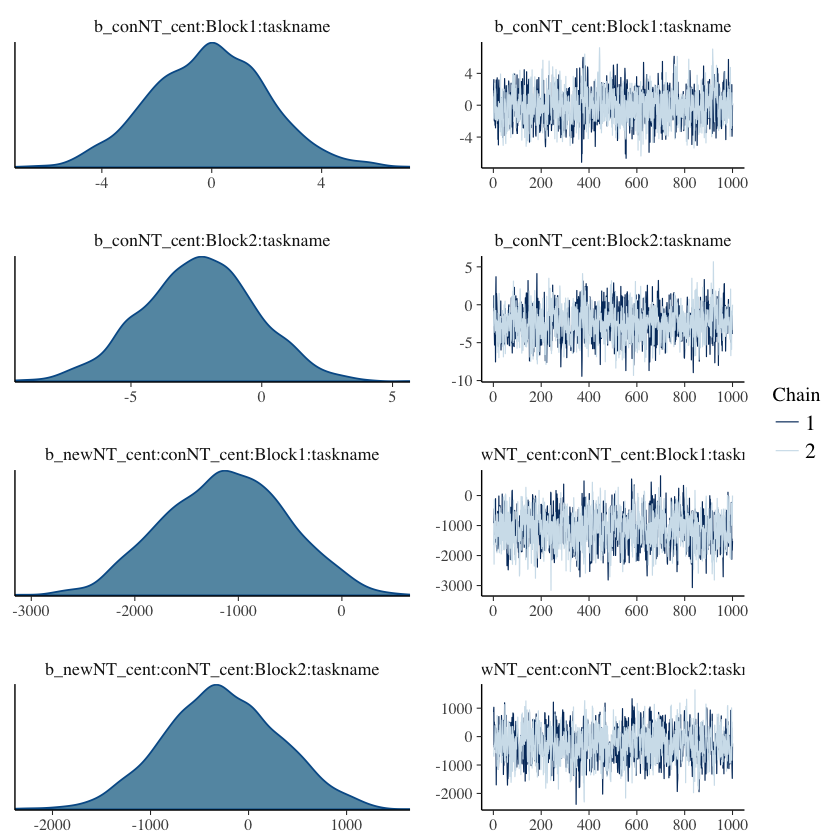

In [24]:
# Only regression weights posteriors
plot(answer_bothNT, pars="^b")

In [25]:
# check distribution of predictions
#pp_check(answer_bothNT)

Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(L

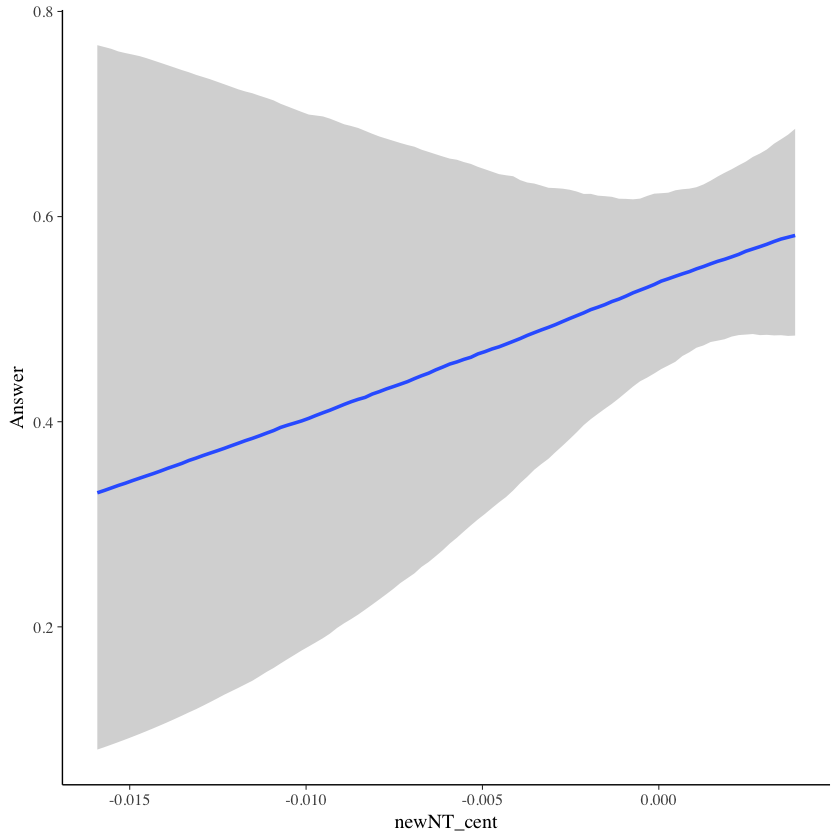

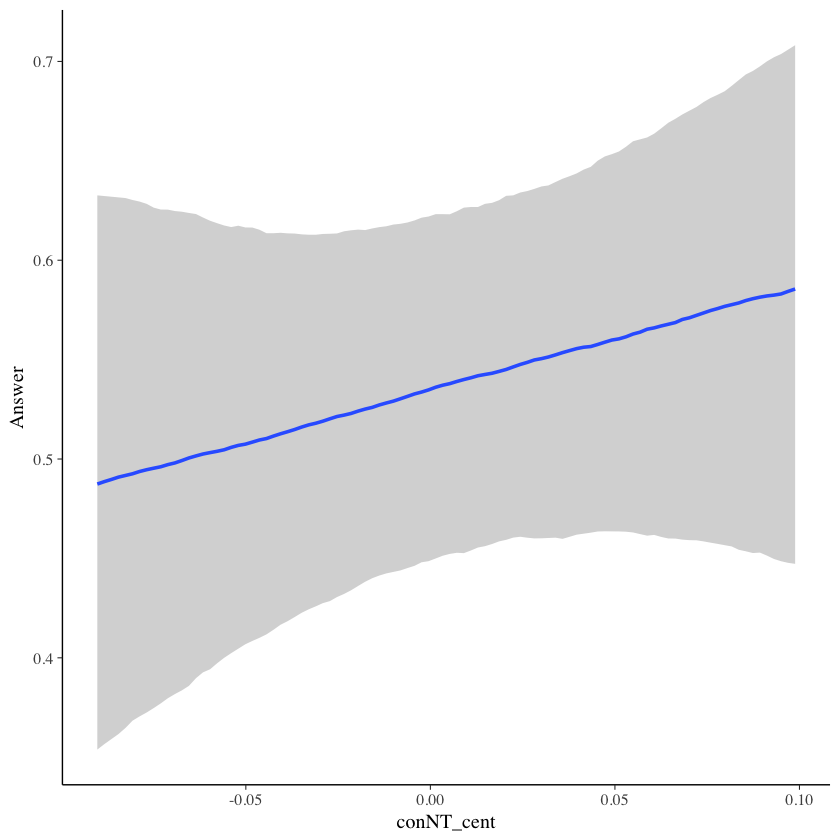

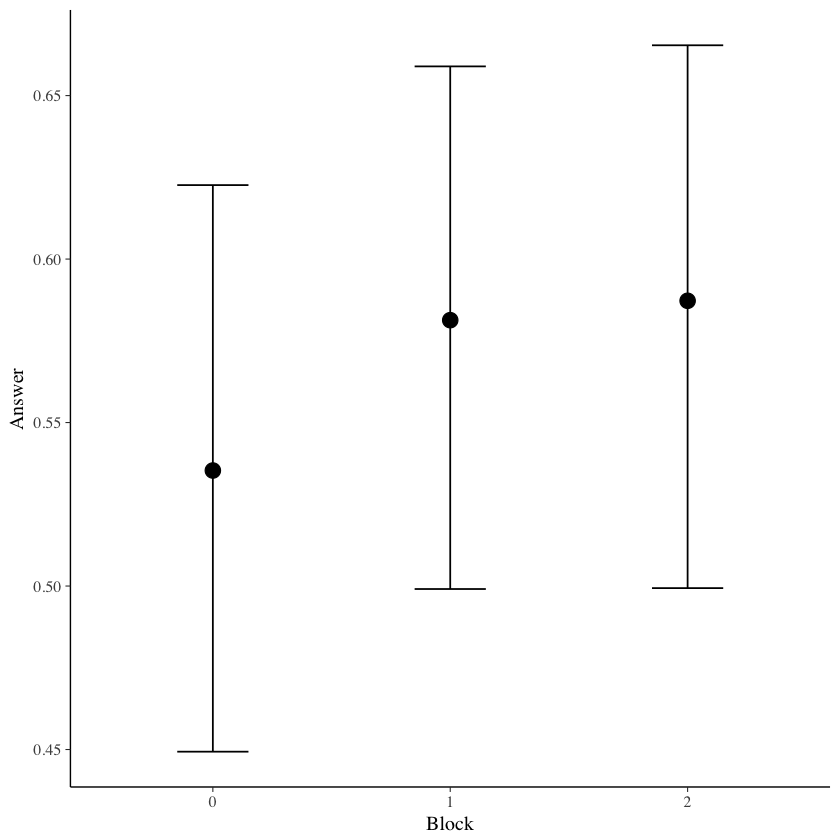

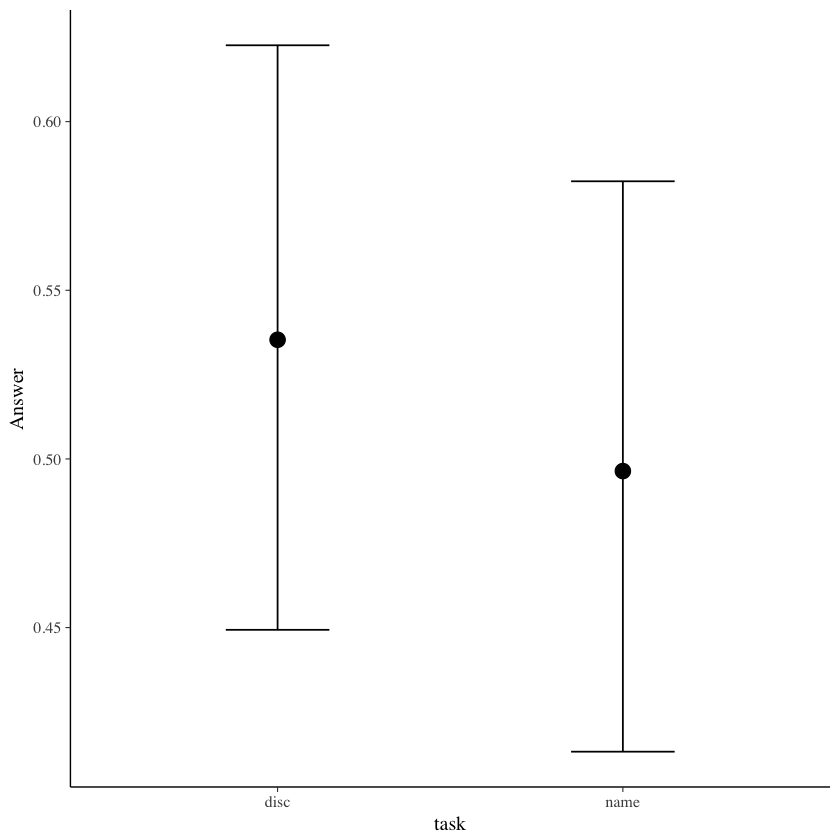

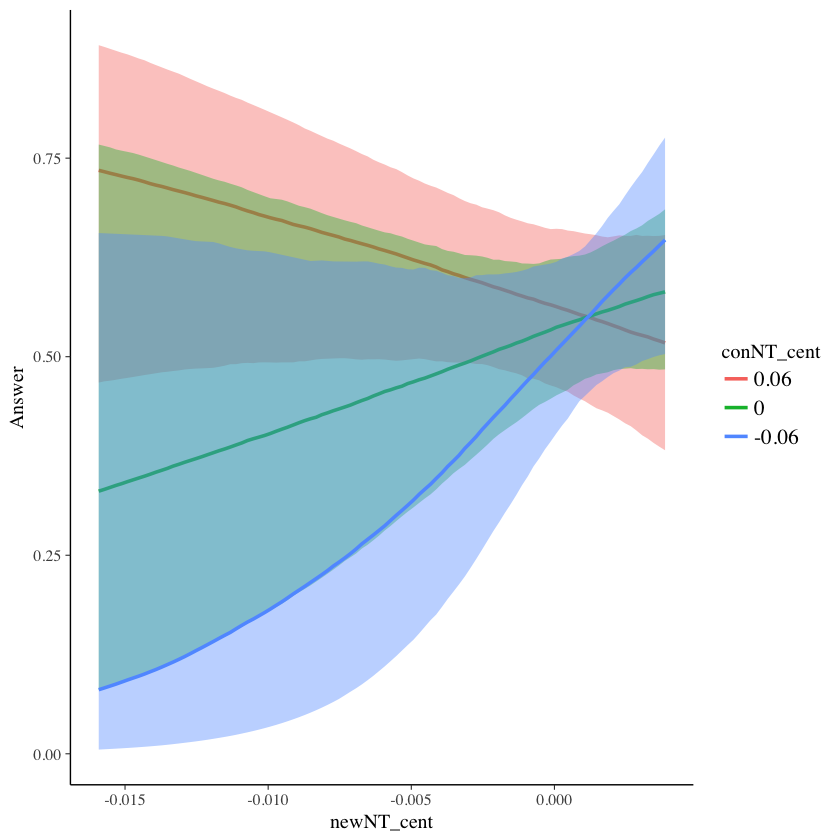

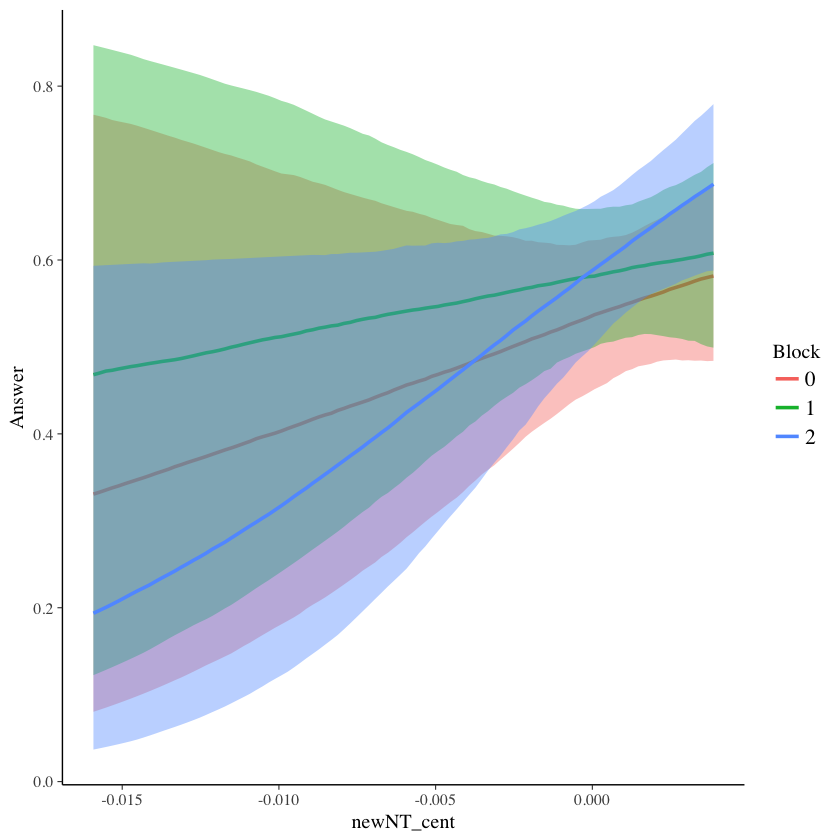

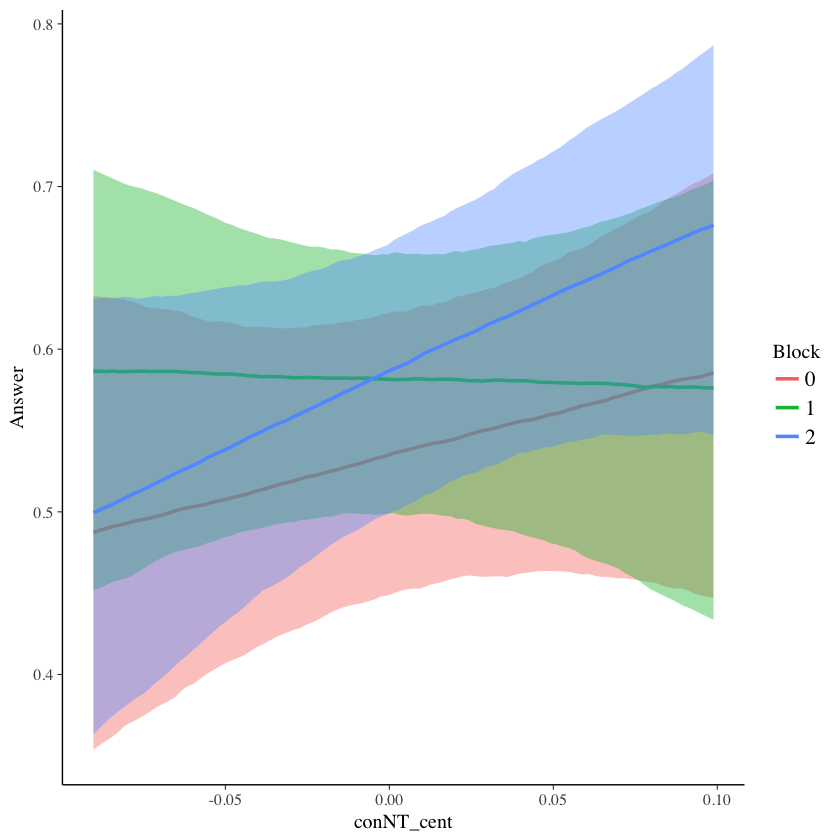

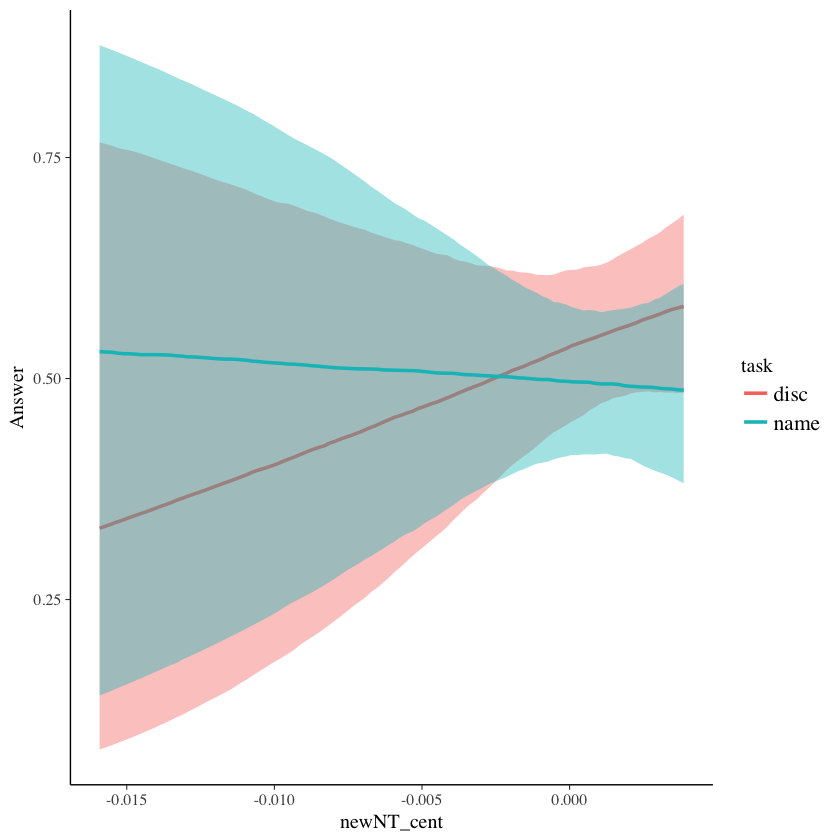

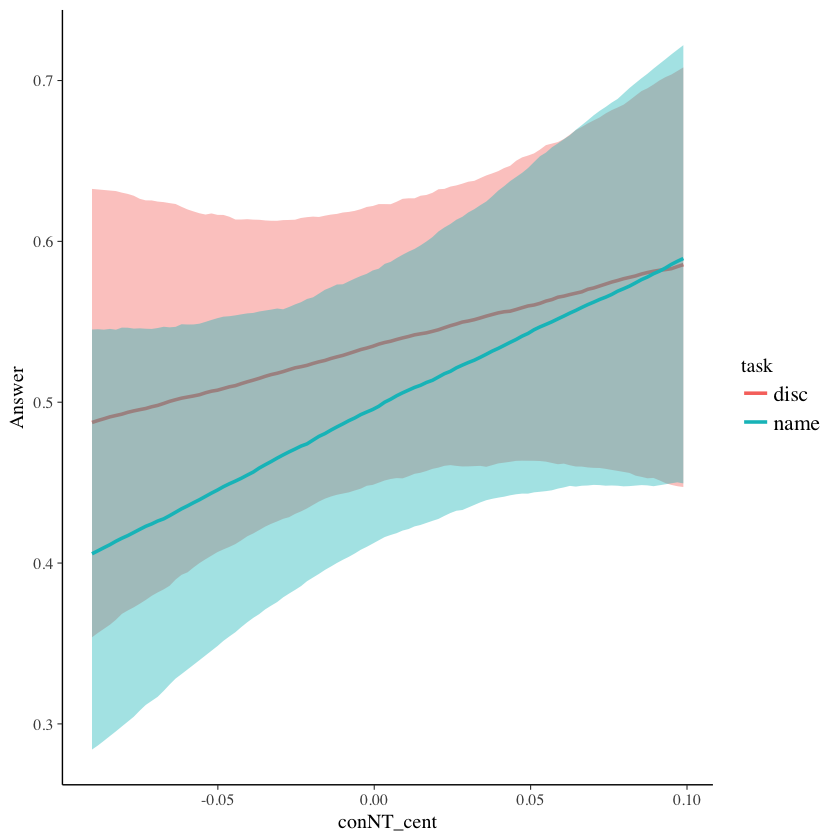

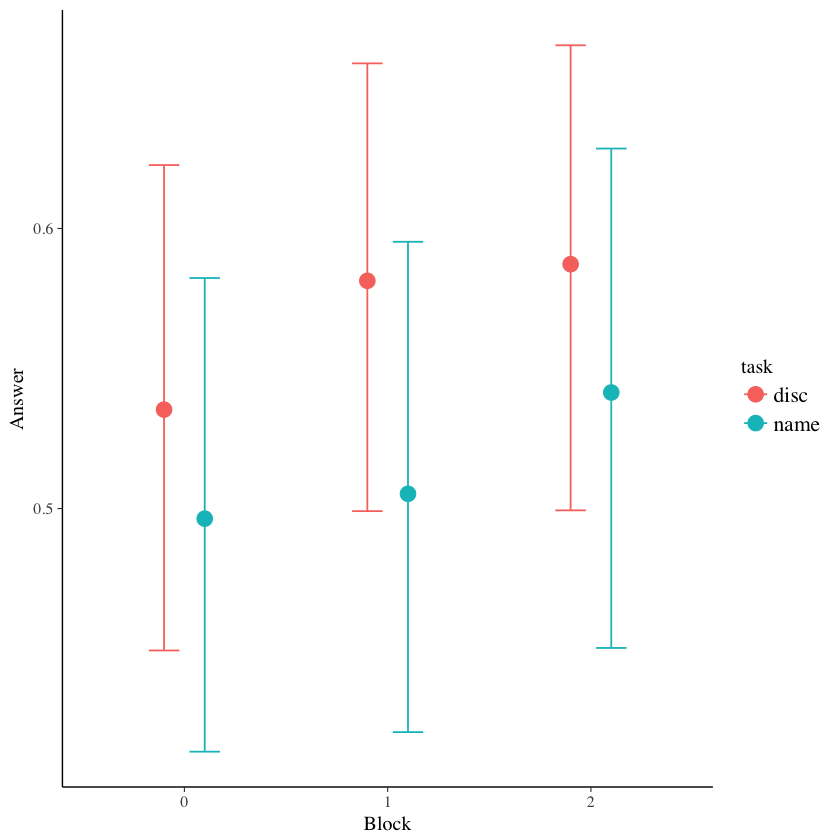

In [26]:
# Prediction by marginalized effects
plot(marginal_effects(answer_bothNT), ask = FALSE)

# Sandbox

## Hypothesis testing (main effects)

In [27]:
#model_weights(answer_bothNT)  # takes long

In [28]:
hblock1 <- hypothesis(answer_bothNT, "Block1 = 0")

In [29]:
print(hblock1)

Hypothesis Tests for class b:
    Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1 (Block1) = 0     0.19      0.09     0.02     0.36         NA        NA    *
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


In [30]:
hblock2 <- hypothesis(answer_bothNT, "Block2 = 0")

In [31]:
print(hblock2)

Hypothesis Tests for class b:
    Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1 (Block2) = 0     0.21      0.09     0.03     0.38         NA        NA    *
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


In [32]:
hblock3 <- hypothesis(answer_bothNT, "Block2 = Block 1")

In [33]:
print(hblock3)

Hypothesis Tests for class b:
             Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (Block2)-(Block1) = 0     0.02      0.09    -0.16      0.2         NA
  Post.Prob Star
1        NA     
---
'*': The expected value under the hypothesis lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


So both block 2 and 3 are significantly different from block 1 (the intercept), but not from each other.

In [34]:
#thepriors <- prior_summary(answer_bothNT)

# TODO

## Interpretability

- Effect coding for categorical predictors (Block)
- Normalize all NT / ED measures by their SD

## Hypothesis testing

- Assess contrasts
- Reduce model complexity and compare with LOO
- Look for estimated SD parameters for random interactions, remove them if they don't appear significant (to reduce complexigy), and run the simpler model(s). Then do model comparison

## Outlier evaluation

- Compare models based on data including and excluding outliers.